In [61]:
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from biosppy.signals import ecg
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [62]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set filepath
filepath = 'PTB_processed_new'
total = len(os.listdir(filepath))

# Load label file
labels_file = pd.read_csv("new_labels.csv", header=0)
labels = np.asarray(labels_file['diagnosis'])

# Create empty containers
signal_array = []  # To store all segments
label_array = []   # To store all labels

# Create counters
files_completed = 0
file_number = 0

In [ ]:
# Signal Extractor
start_time = time.time()
for filename in os.listdir(filepath):
    start_time_file = time.time()
    data = pd.read_csv(os.path.join(filepath, filename), header=0, engine='python')
    file_label = labels[file_number]

    # Extract V2, V3, V4 data
    v2 = np.array(data['v2'])
    v3 = np.array(data['v3'])
    v4 = np.array(data['v4'])

    # Compute peaks based on V4 (or alternatively, use an averaged signal)
    peaks = ecg.christov_segmenter(v4, 1000)[0]

    for peak in range(1, len(peaks) - 1):
        segment_array = []  # To store one segment

        # Extract 3-channel segments (V2, V3, V4)
        for lead in [v2, v3, v4]:
            segment = lead[peaks[peak] - 50:peaks[peak] + 100]  # Extract segment
            segment_array.append(segment)

        signal_array.append(segment_array)
        label_array.append(file_label)

    files_completed += 1
    file_number += 1
    progress = round(files_completed / total * 100, 2)
    end_time_file = time.time()
    elapsed_time_file = round(end_time_file - start_time_file, 2)
    sys.stdout.write(f'\r{filename} loaded - {progress}% completed - Took: {elapsed_time_file} seconds')


signal_array = np.asarray(signal_array)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f'\nData loading completed: {files_completed} files - Took: {elapsed_time} seconds')

le = preprocessing.LabelEncoder()
data_labels = le.fit_transform(label_array)
num_classes = le.classes_.size
print(le.classes_)
print(f'Number of classes: {num_classes}')
print(f'{len(label_array)} Labels loaded')

record513_patient294_Myocardial infarction.csv loaded - 100.0% completed - Took: 0.3 secondsss
Data loading completed: 513 files - Took: 176.53 seconds
['Bundle branch block' 'Cardiomyopathy' 'Dysrhythmia' 'Healthy control'
 'Hypertrophy' 'Myocardial infarction' 'Myocarditis'
 'Valvular heart disease']
Number of classes: 8
9541 Labels loaded


In [68]:
# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(signal_array, data_labels, test_size=0.3, random_state=7)

# Flatten the data to convert each sample to a single feature vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

In [65]:
# Neural Network
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        # Final classifier layer
        self.classifier = nn.Linear(32, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out

    def extract_features(self, x):
        with torch.no_grad():
            return self.feature_extractor(x)


input_dim = X_train.shape[1]
model = MLP(input_dim, num_classes).to(device)

# Training settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Training loop for the PyTorch MLP
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Switch to evaluation mode and extract features
model.eval()
with torch.no_grad():
    train_features = model.extract_features(X_train_tensor).cpu().numpy()
    test_features = model.extract_features(X_test_tensor).cpu().numpy()

Epoch [10/50], Loss: 1.9068
Epoch [20/50], Loss: 1.5014
Epoch [30/50], Loss: 1.2190
Epoch [40/50], Loss: 1.1340
Epoch [50/50], Loss: 1.0407


In [66]:
# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, Y_train)

# Make predictions with the SVM
y_pred_test = svm.predict(test_features)

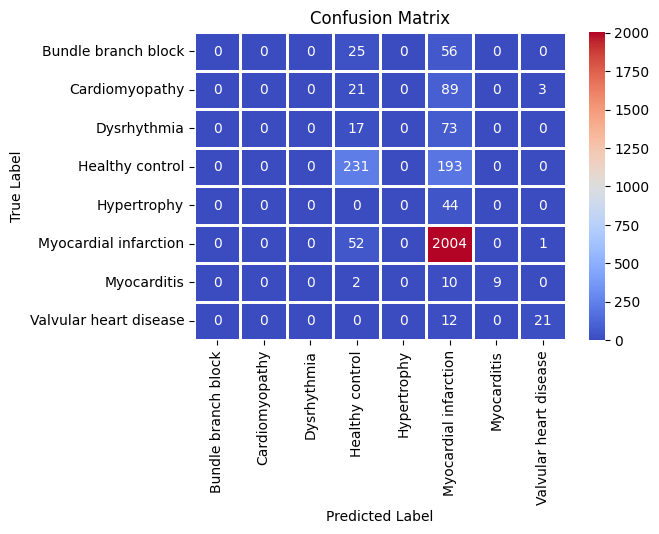

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.00      0.00      0.00       113
           2       0.00      0.00      0.00        90
           3       0.66      0.54      0.60       424
           4       0.00      0.00      0.00        44
           5       0.81      0.97      0.88      2057
           6       1.00      0.43      0.60        21
           7       0.84      0.64      0.72        33

    accuracy                           0.79      2863
   macro avg       0.41      0.32      0.35      2863
weighted avg       0.70      0.79      0.74      2863



c:\INF2008 ML\ECG Project\INF2008-ECG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\INF2008 ML\ECG Project\INF2008-ECG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\INF2008 ML\ECG Project\INF2008-ECG\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [67]:
def show_confusion_matrix(true_labels, predicted_labels):
    matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1,
                xticklabels=le.classes_, yticklabels=le.classes_, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


show_confusion_matrix(Y_test, y_pred_test)
print(classification_report(Y_test, y_pred_test))